In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()


# Variational forms

## Introduction

The variational method consists of choosing a trial wave function, or *variational form*, that depends on one or more parameters, and finding the values of these parameters for which the expectation value of the energy is the lowest possible. The wave function obtained by fixing the parameters to such values is then an approximation to the ground state wave function, and the expectation value of the energy in that state is an upper bound to the ground state energy. Quantum variational algorithms, such as VQE, apply the variational method. As such, they require a variational form. This notebook will walk you through different types of variational forms and how they are implemented in Qiskit. <br>

<img src="figs/vqe.png" width="800">


When we apply a variational form to an initial state $|\psi\rangle$ (which will be discussed in detail in a subsequent section), it generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$ by the linear transformation $U(\theta)$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{min}\rangle$ (where 'closeness' is characterized by either state fidelity, or Manhattan distance), although in practice, we can obtain useful bounds on $E_{gs}$ even if this is not the case. 

Moreover, a fixed variational form with a polynomial number of parameters can only generate transformations to a polynomially sized subspace of all the states in an exponentially sized Hilbert space. Consequently, various variational forms exist. Some, such as $R_y$ and $R_yR_z$, are heuristically designed, without consideration of the target domain. Others, such as UCCSD, utilize domain-specific knowledge to generate close approximations based on the problem's structure. Next we will discuss the structure of common variational forms. 

## Simple variational forms<a id='simplevarform'></a>
When constructing a variational form we must balance two opposing goals. Ideally, our $n$-qubit variational form would be able to generate any possible state $|\psi\rangle$ where $|\psi\rangle \in \mathbb{C}^N$ and $N=2^n$. However, we would like the variational form to use as few parameters as possible. Here, we aim to build intuition for constructing variational forms that satisfy our first goal, while disregarding the second goal for the sake of simplicity. 

Consider the case where $n=1$. The U3 gate takes three parameters: $\theta, \phi$ and $\lambda$, and represents the following transformation:

$$
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align}
$$

Up to a global phase, any possible single-qubit transformation may be implemented by appropriately setting these parameters. Consequently, for the single-qubit case, a variational form capable of generating any possible state is given by the circuit:

<img src="figs/U3_var_form.png" width="300">

Moreover, this universal 'variational form' only has three parameters and thus can be efficiently optimized. It is worth emphasizing that the ability to generate an arbitrary state ensures that during the optimization process, the variational form does not limit the set of attainable states over which the expectation value of $H$ can be taken. Ideally, this ensures that the minimum expectation value is limited only by the capabilities of the classical optimizer. 

A less trivial universal variational form may be derived for the two-qubit case, in which we must consider two-body interactions, and thus entanglement, to achieve universality. Based on the work presented by Shende et al.,<sup>1</sup> the following is an example of a universal parameterized two-qubit circuit:

<img src="figs/two_qubit_var_form.png" width="800">
     
$U(\theta)$ represents the transformation performed by the above circuit. When optimized variationally, the expectation value of $H$ is minimized when $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{min}\rangle$. By formulation, $U(\theta)$ may produce a transformation to any possible state, and so this variational form may obtain an arbitrarily tight bound on two-qubit ground state energies, only limited by the capabilities of the classical optimizer. We will explore categorization of classical optimizers and some of the major algorithms, as well as their relative advantages and disadvantages.

## Structure of common variational forms
We can group variational forms into two categories:

1. Physically motivated variational forms: use domain or application-specific knowledge to limit the set of possible output states. 

2. Hardware-efficient variational forms: use a heuristic circuit without prior domain or application-specific knowledge.

*Physically motivated variational forms* exploit characteristics of the problem domain to restrict the set of required transformations. For example, when calculating the ground state energy of a molecule, the number of particles in the system is known *a priori*. Therefore, if we use a starting state with the correct number of particles, by limiting the variational form to only producing particle-preserving transformations, we greatly reduce the number of parameters required to span the new transformation subspace. Indeed, by utilizing similar information from Coupled-Cluster theory, the variational form UCCSD (see, for instance, work done by Barkoutsos et al. in 2018<sup>2</sup>) can obtain very accurate results for molecular ground state energy estimation when starting from the Hartree Fock state. Another example illustrating the exploitation of domain-specific knowledge follows from considering the set of circuits realizable on real quantum hardware. Current quantum computers, such as those based on superconducting qubits, have limited qubit connectivity. That is, it is not possible to implement two-qubit gates on arbitrary qubit pairs (without inserting swap gates). Thus, variational forms have been constructed for specific quantum computer architectures where the circuits are specifically tuned to maximally exploit the natively available connectivity and gates of a given quantum device. Such a variational form was used in 2017 to successfully implement VQE for the estimation of the ground state energies of molecules as large as BeH$_2$ on an IBM quantum computer.

*Hardware-efficient variational forms:* In this approach, gates are layered such that good approximations on a wide range of states may be obtained. Qiskit supports three such variational forms: $R_yR_z$, $R_y$, and Swap$R_z$. All of these variational forms accept multiple user-specified configurations. Three essential configurations are the number of qubits in the system, the depth setting, and the entanglement setting. A single layer of a variational form specifies a certain pattern of single-qubit rotations and CX gates. The depth setting says how many times the variational form should repeat this pattern. When we increase the depth setting, at the cost of increasing the number of parameters that must be optimized, we increase the set of states the variational form can generate. Finally, the entanglement setting selects the configuration, and implicitly, the number of CX gates. For example, when the entanglement setting is linear, CX gates are applied to adjacent qubit pairs in order (and thus $n-1$ CX gates are added per layer). When the entanglement setting is full, a CX gate is applied to each qubit pair in each layer.  Execute the following code snippet to see the circuits for $R_yR_z$ corresponding to `entanglement="linear"` and `entanglement="full"`:

=============Linear Entanglement:=============


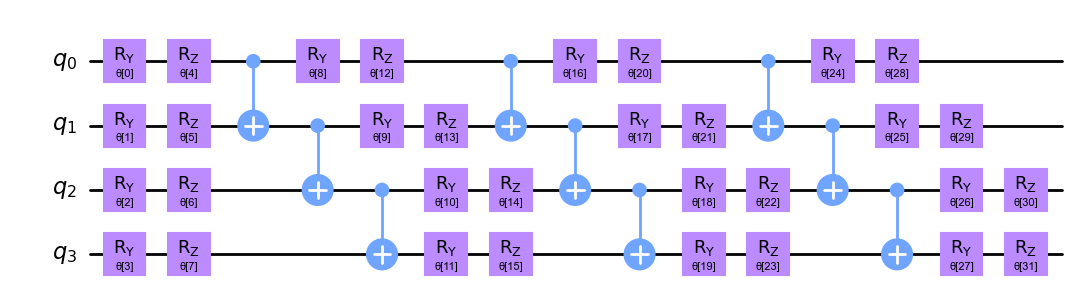

In [2]:
import matplotlib as plt
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
form = EfficientSU2(num_qubits=4, entanglement=entanglements[0], reps=3)
print("=============Linear Entanglement:=============")
form = form.decompose()
        
form.draw(output='mpl')

=============Full Entanglement:=============


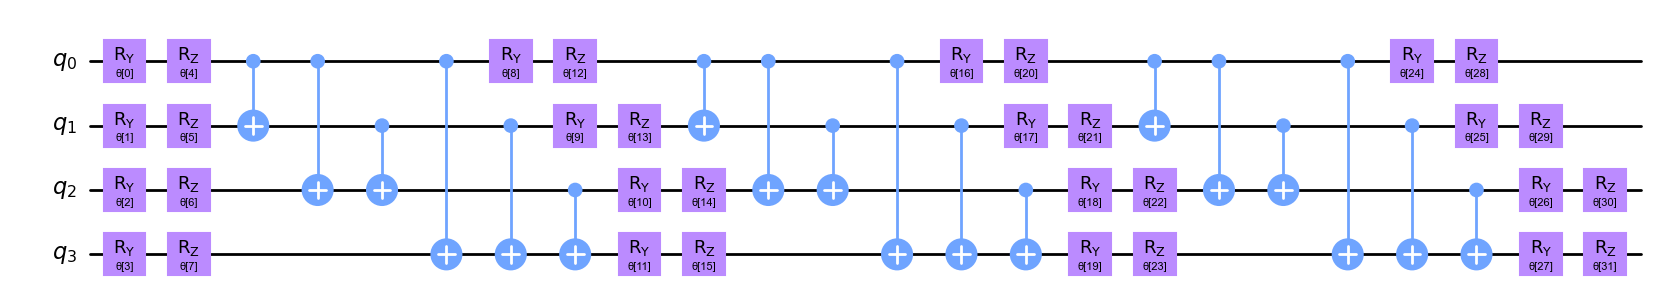

In [3]:
form = EfficientSU2(num_qubits=4, entanglement=entanglements[1], reps=3)
print("=============Full Entanglement:=============")
form = form.decompose()
    
form.draw(output='mpl')

You could also use any available ansatz / initial state or even define your own.

## How to specify a custom gate

As an example, we will implement the hop gate as shown in 'Doubling the size of quantum simulators by entanglement forging' by Eddins et al.
http://arxiv.org/abs/2104.10220

Each hop gate, $h(\varphi)$ , acts according to the following matrix:
\begin{equation*}
h(\varphi) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & cos(\varphi) & -sin(\varphi) & 0 \\
0 & sin(\varphi) & cos(\varphi) & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}
\end{equation*}

In [4]:
from qiskit.circuit import Parameter, QuantumCircuit

theta = Parameter('θ')

hop_gate = QuantumCircuit(2, name='hop_gate')
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

hop_gate.draw()

┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘

## How to specify a custom entanglement map

Then we will use this hop gate to build an ansatz with a custom entangling map

Number of parameters:  4


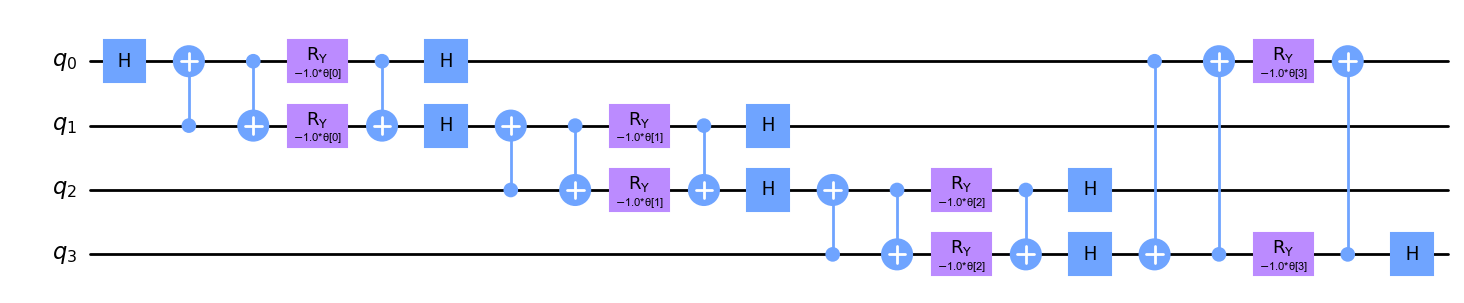

In [5]:
from qiskit.circuit.library import TwoLocal

num_qubits = 4
entangler_map = [[0,1],[1,2],[2,3],[3,0]]

ansatz = TwoLocal(num_qubits, [], hop_gate, entangler_map, reps=1)


print('Number of parameters: ', ansatz.num_parameters)

ansatz.decompose().draw(output='mpl')


## References<a id='references'></a>

<a id='Shende2003'></a>1. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits", *arXiv preprint quant-ph/0308033* (2003).<br>
<a id='Barkoutsos2018'></a>2. Barkoutsos et al., [Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions](https://doi.org/10.1103/PHYSREVA.98.022322) Physical Review A, 2018. <br>
<a id='references'></a>3. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor", *Nature Communications* 5 (2014): 4213.<br>
<a id='references'></a>4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets", *Nature* 549.7671 (2017): 242.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>